In [65]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math 
from tqdm import trange
from matplotlib.table import Table
from scipy.optimize import linprog

In [204]:
class GridWorld:
    def __init__(self,grid_size = 5,a_xy = [0,1], a_prime_xy = [4, 1], b_xy = [0, 3], 
                 b_prime_xy = [2, 3], gamma = 0.9, a_reward = 10, b_reward = 5, penalty = -1.0):
        self.grid_size = grid_size
        self.A_xy  = a_xy
        self.A_prime_xy = a_prime_xy
        self.A_reward = a_reward
        self.B_xy = b_xy
        self.B_prime_xy = b_prime_xy
        self.B_reward = b_reward
        self.discount = gamma
        self.actions = [np.array([0, -1]),
                   np.array([-1, 0]),
                   np.array([0, 1]),
                   np.array([1, 0])]
#         self.actions2 = [np.array([0, -1]),
#                    np.array([1, 0]),
#                    np.array([-1, 0]),
#                    np.array([0, 1])]
        self.action_prob = 1/len(self.actions)
        print('action prob : ',self.action_prob)
        self.penalty_reward = penalty
        self.num_states = self.grid_size*self.grid_size
        
    
    def step(self, state, action):
        if state == self.A_xy:
            return self.A_prime_xy, self.A_reward
        if state == self.B_xy:
            return self.B_prime_xy, self.B_reward
        next_state = (np.array(state) + action).tolist()
        x, y = next_state
        if x < 0 or x >= self.grid_size or y < 0 or y >= self.grid_size:
            reward = self.penalty_reward
            next_state = state
        else:
            reward = 0
        return next_state, reward
    
    
    def solveBellManLinear(self):
        A = np.zeros((self.num_states,self.num_states))
        B = np.zeros(self.num_states)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                r = i * self.grid_size + j
                
                #print(r)
                tot_reward = 0
                for action in self.actions:
                    (next_i, next_j), reward = self.step([i, j], action)
#                     if r == 1:
#                         print(f'i:{i},j:{j}')
#                         print(action)
#                         print(f'next_i:{next_i},next_j:{next_j}')
                    c = next_i * self.grid_size + next_j
                    A[r,c] += self.discount * self.action_prob
                    tot_reward += self.action_prob * reward
                B_idx = i * self.grid_size + j
                if tot_reward != 0.0:
                    tot_reward *= -1
                B[B_idx] = tot_reward
                
        for i in range(A.shape[0]):
            for j in range(A.shape[1]):
                if i == j:
                    A[i][j] -= 1
#         print(A)
#         print('*'*100)
#         print(B)
#         print('*'*100)
#         print(np.linalg.det(A))
        values = np.linalg.solve(A, B)
        values = values.reshape(self.grid_size,self.grid_size)
        return values 
    
        
    def solveBellManNonLinear(self):
        num_actions = len(self.actions)
        shape0 = num_actions * self.num_states
        A = np.zeros((shape0, self.num_states))
        B = np.zeros(shape0)
        C = np.ones(self.num_states)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                r = i * self.grid_size + j
                tot_reward = 0
                cnt  = 0
                for action in self.actions:
                    k = r * num_actions + cnt
                    (next_i, next_j), reward = self.step([i, j], action)
                    #if r == 1:
                        #print(k)
                        #print(f'i:{i},j:{j}')
                        #print(action)
                        #print(f'next_i:{next_i},next_j:{next_j}')
                    c = next_i * self.grid_size + next_j
                    A[k,c] = self.discount 
                    A[k,r] -= 1
                    tot_reward = reward
                    if tot_reward != 0.0:
                        tot_reward *= -1
                    B[k] = tot_reward
                    cnt += 1
        
        res = linprog(C, A_ub = A, b_ub = B)
        values = res['x'].reshape(self.grid_size,self.grid_size)
        #print(values)
        return values

In [205]:
def plotGrid(value,title):
    value = np.round(value, decimals=1)
    fig, ax = plt.subplots()
    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])

    nrows, ncols = value.shape
    width, height = 1.0 / ncols, 1.0 / nrows
    for (i, j), val in np.ndenumerate(value):
        tb.add_cell(i, j, width, height, text=val,
                    loc='center')
    ax.add_table(tb)
    plt.title(title)
    plt.show()
    

In [206]:
def figure3_2():
    grid = GridWorld()
    value = grid.solveBellManLinear()
    title = 'v(s) with random policy'
    plotGrid(value,title)

In [210]:
def figure3_5():
    grid = GridWorld()
    value = grid.solveBellManNonLinear()
    title = r'$v_*(s)$' + ' with optimal policy'
    plotGrid(value,title)

action prob :  0.25


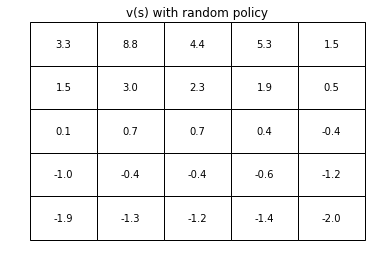

In [211]:
figure3_2()

action prob :  0.25


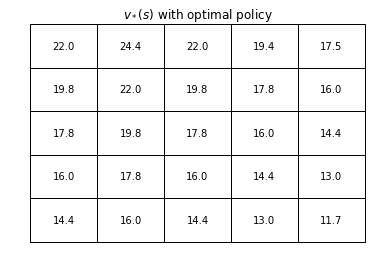

In [212]:
figure3_5()